# Inerpretation-Net Training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes

config = {
    'data': {
        'd': 3, #degree
        'n': 15, #number of variables
        'monomial_vars': None, #int or None
        'laurent': False, #use Laurent polynomials (negative degree with up to -d)  
        'neg_d': 0,#int or None
        'neg_d_prob': 0,
        'sparsity': None,
        'sample_sparsity': 15,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 50000,
        'noise': 0,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'shift_polynomial': False,
        
        'border_min': 0.2, # defines an intervall. Value is randomly chosen and defines the minimum gap between x_min / x_max and the outermost stationary points => two values (left and right gap will be generated per variable)
        'border_max': 0.4,
        'lower_degree_prob': 0.5, # probability that the degree of the whole polynomial will be reduced
        'a_random_prob': 0.5, # probability that a random generated function is used without adjustement
                
        'global_stationary_prob': 1, # probability that all variables are used for adjustement (0 recommended for higher number of variables)
        'bulge_min': 1, # bulge_min and bulge_max define an intervall of how much the function is bulged
        'bulge_max': 4,
        'min_variables_used': 2, # defines an Intervall of how many variables are used to get stationary points and therefore adjust the function
        'max_variables_used': 6,
        'max_monomials': 7, # maximum number of monomials, before adjusting the function (monomial of degree 0 is always defined, but is included in this number)
        'max_monomials_random': 10, #maximum number of monomials for random generated functions
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'early_stopping_min_delta_lambda': 1e-4,
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sample_sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 5000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0,
        'dropout_output': 0,
        'epochs': 2000, 
        'early_stopping': True,
        'batch_size': 256,
        'dense_layers': [4096, 2048, 1024, 512],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 50000,
                
        'interpretation_net_output_monomials': 15, #(None, int) #CONSTANT IS NOT INCLUDED
        'interpretation_net_output_shape': None, #calculated automatically later
        'test_size': 100, #Float for fraction, Int for number 0
        
        'normalize_inet_data': False,
        'inet_training_without_noise': False, #dataset size without noise hardcoded to 50k in generate_paths
        'sparse_poly_representation_version': 1, #(1, 2); 1=old, 2=new

        'evaluate_with_real_function': False, #False
        'consider_labels_training': False, #False
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 100,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 100,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        'max_optimization_minutes': 30,
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
        'per_network_optimization_dataset_size': 5000,
        
        'adjusted_symbolic_metamodeling_code': False,
        'symbolic_metamodeling_evaluation': True,
        'symbolic_metamodeling_poly_evaluation': False,
        'symbolic_metamodeling_function_evaluation': False,
        'symbolic_metamodeling_poly_function_evaluation': False,
        
        
        'symbolic_regression_evaluation': True,
        'per_network_evaluation': False,
    },
    'computation':{
        'train_model': True,
        'n_jobs': 20,
        'use_gpu': True,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
tf.get_logger().setLevel('WARNING')
tf.autograph.set_verbosity(2)

from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score

from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


import tensorflow.keras.backend as K
from livelossplot import PlotLossesKerasTF
#from keras_tqdm import TQDMNotebookCallback

from matplotlib import pyplot as plt
import seaborn as sns

import random 

from IPython.display import Image
from IPython.display import display, Math, Latex, clear_output



In [4]:
tf.__version__

'2.6.0'

In [5]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

data_reshape_version = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' if use_gpu else ''

#os.environ['XLA_FLAGS'] =  '--xla_gpu_cuda_data_dir=/usr/local/cuda-10.1'

#os.environ['XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
#os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda' if use_gpu else ''#-10.1' #--xla_gpu_cuda_data_dir=/usr/local/cuda, 
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2, --tf_xla_enable_xla_devices' if use_gpu else ''#'--tf_xla_auto_jit=2' #, --tf_xla_enable_xla_devices


sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

sys.path.append('..')

In [6]:
from utilities.utility_functions import flatten, rec_gen, gen_monomial_identifier_list

list_of_monomial_identifiers_extended = []

if laurent:
    variable_sets = [list(flatten([[_d for _d in range(d+1)], [-_d for _d in range(1, neg_d+1)]])) for _ in range(n)]
    list_of_monomial_identifiers_extended = rec_gen(variable_sets)    
        
    print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
    #print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
    #print('Sparsity:' + str(sparsity))
    if len(list_of_monomial_identifiers_extended) < 500:
        print(list_of_monomial_identifiers_extended)     
        
    list_of_monomial_identifiers = []
    for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
        if np.sum(monomial_identifier) <= d:
            if monomial_vars == None or len(list(filter(lambda x: x != 0, monomial_identifier))) <= monomial_vars:
                list_of_monomial_identifiers.append(monomial_identifier)        
else:
    variable_list = ['x'+ str(i) for i in range(n)]
    list_of_monomial_identifiers = gen_monomial_identifier_list(variable_list, d, n)
            
print('List length: ' + str(len(list_of_monomial_identifiers)))
#print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
#print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


List length: 816
[[3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In [7]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis
config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda
config['i_net']['data_reshape_version'] = data_reshape_version

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d']) if not laurent else len(list_of_monomial_identifiers)
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else config['data']['sparsity']*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials'] if config['i_net']['sparse_poly_representation_version'] == 1 else config['data']['n']*(config['data']['d']+1)*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials']  
print('Output Shape: ', config['i_net']['interpretation_net_output_shape'])

transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sample_sparsity')*config['data']['sample_sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

Output Shape:  12255


In [8]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense4096-2048-1024-512-output_12255_drop0e2000b256_custom/lnets_50000_75-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_15_d_3_negd_0_prob_0_spars_15_amin_-1_amax_1_xdist_uniform_noise_normal_0
lnets_50000_75-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_15_d_3_negd_0_prob_0_spars_15_amin_-1_amax_1_xdist_uniform_noise_normal_0


In [9]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  1
Num XLA-GPUs Available:  1


## Load Data and Generate Datasets

In [10]:
def load_lambda_nets(index, no_noise=False):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path_identifier_lambda_net_data_loading = None 
                
    if no_noise==True:
        path_identifier_lambda_net_data_loading = generate_paths(path_type='interpretation_net_no_noise')['path_identifier_lambda_net_data']
    else:
        path_identifier_lambda_net_data_loading = path_identifier_lambda_net_data 
        
    directory = './data/weights/' + 'weights_' + path_identifier_lambda_net_data_loading + '/'
    path_weights = directory + 'weights_epoch_' + str(index).zfill(3) + '.txt'
    path_X_data = directory + 'lambda_X_test_data.txt'
    path_y_data = directory + 'lambda_y_test_data.txt'        
    
    weight_data = pd.read_csv(path_weights, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_X_test_data = pd.read_csv(path_X_data, sep=",", header=None)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_y_test_data = pd.read_csv(path_y_data, sep=",", header=None)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
        
    lambda_nets = [None] * weight_data.shape[0]
    for i, (row_weights, row_lambda_X_test_data, row_lambda_y_test_data) in enumerate(zip(weight_data.values, lambda_X_test_data.values, lambda_y_test_data.values)):        
        lambda_net = LambdaNet(row_weights, row_lambda_X_test_data, row_lambda_y_test_data)
        lambda_nets[i] = lambda_net
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [11]:
#LOAD DATA
if inet_training_without_noise:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list_without_noise = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1, no_noise=True) for i in epochs_save_range_lambda)  
    del parallel
    
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel
else:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=20)]: Using backend MultiprocessingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed: 15.2min finished


## Data Inspection

In [12]:
lambda_net_dataset.as_pandas().head()

seed  300000000000000-target  210000000000000-target  \
33553  1373158606                   0.000                   0.000   
9427   1373158606                   0.000                   0.000   
199    1373158606                   0.000                   0.000   
12447  1373158606                   0.000                   0.000   
39489  1373158606                   0.000                   0.000   

       201000000000000-target  200100000000000-target  200010000000000-target  \
33553                   0.000                   0.000                   0.000   
9427                    0.000                   0.000                   0.000   
199                     0.000                   0.000                   0.000   
12447                   0.000                   0.000                   0.000   
39489                   0.000                   0.000                   0.000   

       200001000000000-target  200000100000000-target  200000010000000-target  \
33553                   0.000                   0.000                   0.000   
9427                    0.000                   0.000                   0.000   
199                     0.000                   0.000                   0.000   
12447                   0.000                   0.000                   0.000   
39489                   0.000                   0.000                   0.000   

       200000001000000-target  200000000100000-target  200000000010000-target  \
33553                   0.000                   0.000                   0.000   
9427                    0.000                   0.000                   0.000   
199                     0.000                   0.000                   0.000   
12447                   0.000                   0.000                   0.000   
39489                   0.000                   0.000                   0.000   

       200000000001000-target  200000000000100-target  200000000000010-target  \
33553                   0.000                   0.000                   0.000   
9427                    0.000                   0.000                   0.000   
199                     0.000                   0.000                   0.000   
12447                   0.000                   0.000                   0.000   
39489                   0.000                   0.000                   0.000   

       200000000000001-target  200000000000000-target  120000000000000-target  \
33553                  -0.538                   0.000                   0.000   
9427                    0.000                   0.000                   0.000   
199                     0.000                   0.000                   0.000   
12447                   0.000                   0.000                   0.000   
39489                   0.000                   0.000                   0.000   

       111000000000000-target  110100000000000-target  110010000000000-target  \
33553                   0.000                   0.000                   0.000   
9427                    0.000                   0.000                   0.000   
199                     0.000                   0.000                   0.000   
12447                   0.000                   0.000                   0.000   
39489                   0.000                   0.000                   0.000   

       110001000000000-target  110000100000000-target  110000010000000-target  \
33553                   0.000                   0.000                   0.000   
9427                    0.000                   0.000                   0.000   
199                     0.000                   0.000                   0.000   
12447                   0.000                   0.000                   0.000   
39489                   0.000                   0.000                   0.000   

       110000001000000-target  110000000100000-target  110000000010000-target  \
33553                   0.000                   0.000                   0.000   
9427                    0.0

In [13]:
lambda_net_dataset.as_pandas().describe()

seed  300000000000000-target  210000000000000-target  \
count      50000.000               50000.000               50000.000   
mean  1373158606.000                   0.000                  -0.001   
std            0.000                   0.080                   0.079   
min   1373158606.000                  -1.000                  -0.999   
25%   1373158606.000                   0.000                   0.000   
50%   1373158606.000                   0.000                   0.000   
75%   1373158606.000                   0.000                   0.000   
max   1373158606.000                   0.999                   0.999   

       201000000000000-target  200100000000000-target  200010000000000-target  \
count               50000.000               50000.000               50000.000   
mean                   -0.000                  -0.000                   0.000   
std                     0.079                   0.078                   0.078   
min                    -1.000                  -0.999                  -0.999   
25%                     0.000                   0.000                   0.000   
50%                     0.000                   0.000                   0.000   
75%                     0.000                   0.000                   0.000   
max                     0.998                   0.999                   0.999   

       200001000000000-target  200000100000000-target  200000010000000-target  \
count               50000.000               50000.000               50000.000   
mean                   -0.000                   0.000                  -0.000   
std                     0.077                   0.076                   0.078   
min                    -1.000                  -0.993                  -1.000   
25%                     0.000                   0.000                   0.000   
50%                     0.000                   0.000                   0.000   
75%                     0.000                   0.000                   0.000   
max                     0.995                   1.000                   0.998   

       200000001000000-target  200000000100000-target  200000000010000-target  \
count               50000.000               50000.000               50000.000   
mean                   -0.000                  -0.001                  -0.000   
std                     0.077                   0.079                   0.076   
min                    -0.999                  -0.994                  -0.999   
25%                     0.000                   0.000                   0.000   
50%                     0.000                   0.000                   0.000   
75%                     0.000                   0.000                   0.000   
max                     0.999                   0.999                   0.999   

       200000000001000-target  200000000000100-target  200000000000010-target  \
count               50000.000               50000.000               50000.000   
mean                    0.001                  -0.000                   0.001   
std                     0.081                   0.082                   0.076   
min                    -0.998                  -0.999                  -1.000   
25%                     0.000                   0.000                   0.000   
50%                     0.000                   0.000                   0.000   
75%                     0.000                   0.000                   0.000   
max                     1.000                   0.999                   1.000   

       200000000000001-target  200000000000000-target  120000000000000-target  \
count               50000.000               50000.000               50000.000   
mean                    0.000                  -0.000                  -0.000   
std                     0.083                   0.074                   0.079   
min                    -0.998                  -0.995                  -0.999   
25%                     0.000             

In [14]:
lambda_net_dataset.X_test_data_list[0][:10]

array([[0.38552652, 0.85893328, 0.29187315, 0.19343383, 0.52123666,
        0.59019083, 0.13412787, 0.5341219 , 0.64151399, 0.8057584 ,
        0.87983708, 0.93139566, 0.66728709, 0.34877794, 0.42840107],
       [0.71205853, 0.25936418, 0.4661579 , 0.275595  , 0.60299032,
        0.44225351, 0.74078812, 0.16421656, 0.57698249, 0.32163926,
        0.94160009, 0.51922204, 0.63427194, 0.35553118, 0.14602217],
       [0.22761225, 0.46410192, 0.85587147, 0.78402614, 0.7394321 ,
        0.93364333, 0.79513239, 0.61739966, 0.80628223, 0.56272189,
        0.52281992, 0.21583214, 0.08972857, 0.57015432, 0.78359081],
       [0.6152178 , 0.32016125, 0.98379053, 0.75045653, 0.25058907,
        0.4427803 , 0.57633085, 0.25613737, 0.0027403 , 0.45646631,
        0.42609805, 0.21264068, 0.19136925, 0.15511144, 0.65223408],
       [0.57269462, 0.56499733, 0.19646681, 0.16951413, 0.7162537 ,
        0.40584857, 0.98887942, 0.95190879, 0.93463841, 0.88075586,
        0.32614282, 0.31466825, 0.84154144, 

In [15]:
lambda_net_dataset.y_test_data_list[0][:10]

array([[ 0.75814259],
       [ 0.09690917],
       [-0.12004423],
       [-0.565772  ],
       [ 0.80979377],
       [-0.38490412],
       [ 0.39194211],
       [ 1.3253423 ],
       [-0.38775843],
       [-0.04691821]])

## Generate Datasets for Interpretation-Net training

In [16]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []


if inet_training_without_noise:
   
    for lambda_net_dataset, lambda_net_dataset_without_noise in zip(lambda_net_dataset_list, lambda_net_dataset_list_without_noise):
        if inet_holdout_seed_evaluation:
            raise SystemExit('Holdout Evaluation not implemented with inet training without noise')
            
        else:
            lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_dataset_without_noise, test_split=0.1)

            _, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset, lambda_net_dataset_list_without_noise
        
else:

    for lambda_net_dataset in lambda_net_dataset_list:

        if inet_holdout_seed_evaluation:

            complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

            random.seed(RANDOM_SEED)

            if isinstance(test_size, float):
                test_size = int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-test_size)))

            test_seeds = random.sample(complete_seed_list, test_size)
            lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
            complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)

            random.seed(RANDOM_SEED)
            valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-0.1))))
            lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
            complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

            train_seeds = complete_seed_list
            lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset
        else:

            lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
            lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset, lambda_net_train_with_valid_dataset


del lambda_net_dataset_list

In [17]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(44910, 3725)

In [18]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(4990, 3725)

In [19]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(100, 3725)

In [20]:
lambda_net_train_dataset_list[-1].as_pandas().head()

seed  300000000000000-target  210000000000000-target  \
9901   1373158606                   0.000                   0.000   
5910   1373158606                   0.000                   0.000   
18619  1373158606                   0.000                   0.000   
33312  1373158606                   0.000                   0.000   
47430  1373158606                   0.000                   0.000   

       201000000000000-target  200100000000000-target  200010000000000-target  \
9901                    0.000                   0.000                   0.000   
5910                    0.000                   0.000                   0.000   
18619                   0.000                   0.000                   0.000   
33312                   0.000                   0.000                   0.000   
47430                   0.000                   0.000                   0.000   

       200001000000000-target  200000100000000-target  200000010000000-target  \
9901                    0.000                   0.000                   0.000   
5910                    0.000                   0.000                   0.000   
18619                   0.000                   0.000                   0.000   
33312                   0.000                   0.000                   0.000   
47430                   0.000                   0.000                   0.000   

       200000001000000-target  200000000100000-target  200000000010000-target  \
9901                    0.000                   0.000                   0.000   
5910                    0.000                   0.000                   0.000   
18619                   0.000                   0.000                   0.000   
33312                   0.000                   0.000                   0.000   
47430                   0.000                   0.000                   0.000   

       200000000001000-target  200000000000100-target  200000000000010-target  \
9901                    0.000                   0.000                   0.000   
5910                    0.000                   0.000                   0.000   
18619                   0.000                   0.000                   0.000   
33312                   0.000                   0.000                   0.000   
47430                   0.000                   0.000                   0.000   

       200000000000001-target  200000000000000-target  120000000000000-target  \
9901                    0.000                   0.000                   0.000   
5910                    0.000                   0.000                   0.000   
18619                   0.000                   0.000                   0.000   
33312                   0.000                   0.000                   0.000   
47430                   0.000                   0.000                   0.000   

       111000000000000-target  110100000000000-target  110010000000000-target  \
9901                    0.000                   0.000                   0.000   
5910                    0.000                   0.000                   0.000   
18619                   0.000                   0.000                   0.000   
33312                   0.000                   0.000                   0.000   
47430                   0.000                   0.000                   0.000   

       110001000000000-target  110000100000000-target  110000010000000-target  \
9901                    0.000                   0.000                   0.000   
5910                    0.000                   0.000                   0.000   
18619                   0.000                   0.000                   0.000   
33312                   0.000                   0.000                   0.000   
47430                   0.000                   0.000                   0.000   

       110000001000000-target  110000000100000-target  110000000010000-target  \
9901                    0.000                   0.000                   0.000   
5910                    0.0

In [21]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

seed  300000000000000-target  210000000000000-target  \
7038   1373158606                   0.000                   0.000   
30770  1373158606                   0.000                   0.000   
41342  1373158606                   0.000                   0.000   
21084  1373158606                   0.000                   0.000   
47211  1373158606                   0.000                   0.000   

       201000000000000-target  200100000000000-target  200010000000000-target  \
7038                    0.000                   0.000                   0.000   
30770                   0.000                   0.000                   0.000   
41342                   0.000                   0.000                   0.000   
21084                   0.000                   0.000                   0.000   
47211                   0.000                   0.000                   0.000   

       200001000000000-target  200000100000000-target  200000010000000-target  \
7038                    0.000                   0.000                  -0.021   
30770                   0.000                   0.000                   0.000   
41342                   0.000                   0.000                   0.000   
21084                   0.000                   0.000                   0.000   
47211                   0.000                   0.000                   0.000   

       200000001000000-target  200000000100000-target  200000000010000-target  \
7038                    0.000                   0.000                   0.000   
30770                   0.000                   0.000                   0.000   
41342                   0.000                   0.000                   0.000   
21084                   0.000                   0.000                   0.000   
47211                   0.000                   0.000                   0.000   

       200000000001000-target  200000000000100-target  200000000000010-target  \
7038                    0.000                   0.000                   0.000   
30770                   0.000                   0.000                   0.000   
41342                   0.000                   0.000                   0.000   
21084                   0.000                   0.000                   0.000   
47211                   0.000                   0.000                   0.000   

       200000000000001-target  200000000000000-target  120000000000000-target  \
7038                    0.000                   0.000                   0.000   
30770                   0.000                   0.000                   0.000   
41342                   0.000                   0.000                   0.000   
21084                   0.000                   0.000                   0.000   
47211                   0.000                   0.000                   0.000   

       111000000000000-target  110100000000000-target  110010000000000-target  \
7038                    0.000                   0.000                   0.000   
30770                   0.000                   0.000                   0.000   
41342                   0.000                   0.000                   0.000   
21084                   0.000                   0.000                   0.000   
47211                   0.000                   0.000                   0.000   

       110001000000000-target  110000100000000-target  110000010000000-target  \
7038                    0.000                   0.000                   0.000   
30770                   0.000                   0.000                   0.000   
41342                   0.000                   0.000                   0.000   
21084                   0.000                   0.000                   0.000   
47211                   0.000                   0.000                   0.000   

       110000001000000-target  110000000100000-target  110000000010000-target  \
7038                    0.000                   0.000                   0.000   
30770                   0.0

In [22]:
lambda_net_test_dataset_list[-1].as_pandas().head()

seed  300000000000000-target  210000000000000-target  \
35587  1373158606                   0.292                   0.000   
32681  1373158606                   0.000                   0.000   
40971  1373158606                   0.000                   0.000   
21022  1373158606                   0.000                   0.000   
6403   1373158606                   0.000                   0.000   

       201000000000000-target  200100000000000-target  200010000000000-target  \
35587                   0.000                   0.000                   0.000   
32681                   0.000                   0.000                   0.000   
40971                   0.000                   0.000                   0.000   
21022                   0.000                   0.000                   0.000   
6403                    0.000                   0.000                   0.000   

       200001000000000-target  200000100000000-target  200000010000000-target  \
35587                   0.000                   0.000                   0.000   
32681                   0.000                   0.000                   0.000   
40971                   0.000                   0.000                   0.000   
21022                   0.000                   0.000                   0.000   
6403                    0.000                   0.000                   0.000   

       200000001000000-target  200000000100000-target  200000000010000-target  \
35587                   0.000                   0.000                   0.000   
32681                   0.000                   0.000                   0.000   
40971                   0.000                   0.000                   0.000   
21022                   0.000                   0.000                   0.000   
6403                    0.000                   0.000                   0.000   

       200000000001000-target  200000000000100-target  200000000000010-target  \
35587                   0.000                   0.000                   0.000   
32681                   0.000                   0.000                   0.000   
40971                   0.000                   0.000                   0.000   
21022                   0.000                   0.000                   0.000   
6403                    0.000                   0.000                   0.000   

       200000000000001-target  200000000000000-target  120000000000000-target  \
35587                   0.000                   0.000                   0.000   
32681                   0.000                   0.000                   0.000   
40971                   0.000                   0.000                   0.000   
21022                   0.000                   0.894                   0.000   
6403                    0.000                   0.000                   0.000   

       111000000000000-target  110100000000000-target  110010000000000-target  \
35587                   0.000                   0.000                   0.000   
32681                   0.000                   0.000                   0.000   
40971                   0.000                   0.000                   0.000   
21022                   0.034                   0.000                   0.000   
6403                    0.000                   0.000                   0.000   

       110001000000000-target  110000100000000-target  110000010000000-target  \
35587                   0.000                   0.000                   0.000   
32681                   0.000                   0.000                   0.000   
40971                   0.000                   0.000                   0.000   
21022                   0.000                   0.000                   0.000   
6403                    0.000                   0.000                   0.000   

       110000001000000-target  110000000100000-target  110000000010000-target  \
35587                   0.000                   0.000                   0.000   
32681                   0.0

## Interpretation Network Training

In [23]:
#%load_ext autoreload

In [24]:
lambda_net_train_dataset_list[0].weight_list[0].shape

(1276,)

----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------
Epoch 1/2000
176/176 [==============================] - 155s 860ms/step - loss: 0.3045 - r2_inet_lambda_fv_loss: 0.0380 - val_loss: 0.2832 - val_r2_inet_lambda_fv_loss: -0.1122
Epoch 2/2000
176/176 [==============================] - 151s 856ms/step - loss: 0.2826 - r2_inet_lambda_fv_loss: -0.1114 - val_loss: 0.2820 - val_r2_inet_lambda_fv_loss: -0.1203
Epoch 3/2000
176/176 [==============================] - 151s 860ms/step - loss: 0.2804 - r2_inet_lambda_fv_loss: -0.1252 - val_loss: 0.2799 - val_r2_inet_lambda_fv_loss: -0.1309
Epoch 4/2000
176/176 [==============================] - 151s 858ms/step - loss: 0.2815 - r2_inet_lambda_fv_loss: -0.1190 - val_loss: 0.2840 - val_r2_inet_lambda_fv_loss: -0.1053
Epoch 5/2000
176/176 [==============================] - 149s 848ms/step - loss: 0.2816 - r2_inet_lambda_fv_loss: -0.1186 - val_loss: 0.2815 - val_r2_inet_lambda_fv_l

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



176/176 [==============================] - 151s 855ms/step - loss: 0.2479 - r2_inet_lambda_fv_loss: -0.2991 - val_loss: 0.2783 - val_r2_inet_lambda_fv_loss: -0.1363
Epoch 80/2000
176/176 [==============================] - 151s 855ms/step - loss: 0.2479 - r2_inet_lambda_fv_loss: -0.2993 - val_loss: 0.2780 - val_r2_inet_lambda_fv_loss: -0.1388
Epoch 81/2000
176/176 [==============================] - 151s 861ms/step - loss: 0.2474 - r2_inet_lambda_fv_loss: -0.3016 - val_loss: 0.2775 - val_r2_inet_lambda_fv_loss: -0.1407
Epoch 82/2000
176/176 [==============================] - 151s 859ms/step - loss: 0.2476 - r2_inet_lambda_fv_loss: -0.3009 - val_loss: 0.2774 - val_r2_inet_lambda_fv_loss: -0.1422
Epoch 83/2000
176/176 [==============================] - 152s 863ms/step - loss: 0.2469 - r2_inet_lambda_fv_loss: -0.3043 - val_loss: 0.2779 - val_r2_inet_lambda_fv_loss: -0.1408
Epoch 84/2000
176/176 [==============================] - 149s 848ms/step - loss: 0.2473 - r2_inet_lambda_fv_loss: -0.30

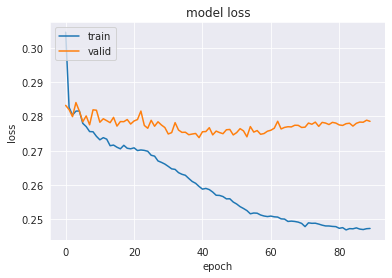

In [25]:
#%autoreload 2
((X_valid_list, y_valid_list), 
 (X_test_list, y_test_list),
 history_list, 

 #scores_valid_list,
 #scores_test_list, 

 #function_values_valid_list, 
 #function_values_test_list, 

 #polynomial_dict_valid_list,
 #polynomial_dict_test_list,

 #distrib_dict_valid_list,
 #distrib_dict_test_list,

 model_list) = interpretation_net_training(lambda_net_train_dataset_list, 
                                           lambda_net_valid_dataset_list, 
                                           lambda_net_test_dataset_list)



In [26]:
model_list[-1].summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 1276)]       0                                            
__________________________________________________________________________________________________
hidden1_4096 (Dense)            (None, 4096)         5230592     input[0][0]                      
__________________________________________________________________________________________________
activation1_relu (Activation)   (None, 4096)         0           hidden1_4096[0][0]               
__________________________________________________________________________________________________
hidden2_2048 (Dense)            (None, 2048)         8390656     activation1_relu[0][0]           
______________________________________________________________________________________________

In [27]:
#polynomial_dict_valid_list = []
polynomial_dict_test_list = []  


for lambda_net_valid_dataset, lambda_net_test_dataset in zip(lambda_net_valid_dataset_list, lambda_net_test_dataset_list):

    #polynomial_dict_valid = {'lstsq_lambda_pred_polynomials': lambda_net_valid_dataset.lstsq_lambda_pred_polynomial_list,
    #                        'lstsq_target_polynomials': lambda_net_valid_dataset.lstsq_target_polynomial_list,
    #                        'target_polynomials': lambda_net_valid_dataset.target_polynomial_list}    

    polynomial_dict_test = {'lstsq_lambda_pred_polynomials': lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list,
                            'lstsq_target_polynomials': lambda_net_test_dataset.lstsq_target_polynomial_list,
                            'target_polynomials': lambda_net_test_dataset.target_polynomial_list}    

    #polynomial_dict_valid_list.append(polynomial_dict_valid)  
    polynomial_dict_test_list.append(polynomial_dict_test)


In [28]:
print('---------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------- PREDICT INET ------------------------------------------------------')

start = time.time() 

for i, (X_test, model) in enumerate(zip(X_test_list, model_list)):
    #y_test_pred = model.predict(X_test)    
    #print(model.summary())
    #print(X_test.shape)
    y_test_pred = make_inet_prediction(model, X_test, network_data=None, lambda_trained_normalized=False, inet_training_normalized=normalize_inet_data, normalization_parameter_dict=None)
    #print(y_test_pred.shape)   
    polynomial_dict_test_list[i]['inet_polynomials'] = y_test_pred


end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('Predict Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')

---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------- PREDICT INET ------------------------------------------------------
Predict Time: 0:00:00
---------------------------------------------------------------------------------------------------------------------------


In [29]:
if symbolic_metamodeling_poly_evaluation:
    print('-------------------------------------------------- CALCULATE METAMODEL POLY -----------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        
        metamodel_functions_test = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=False, force_polynomial=True)
        polynomial_dict_test_list[i]['metamodel_poly'] = metamodel_functions_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Metamodel Poly Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------') 

In [30]:
if symbolic_metamodeling_evaluation:
    print('---------------------------------------------------- CALCULATE METAMODEL --------------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        metamodel_functions_test = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=False, force_polynomial=False)
        polynomial_dict_test_list[i]['metamodel_functions'] = metamodel_functions_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Metamodel Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------') 

---------------------------------------------------- CALCULATE METAMODEL --------------------------------------------------


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is de


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]


  0%|          | 0/15 [00:00<?, ?it/s]

 40%|████      | 4/10 [14:40<22:01, 220.24s/it][Parallel(n_jobs=20)]: Done  27 tasks      | elapsed: 60.3min
[Parallel(n_jobs=20)]: Done  28 tasks      | elapsed: 60.3min
 40%|████      | 4/10 [13:21<20:02, 200.36s/it][Parallel(n_jobs=20)]: Done  34 tasks      | elapsed: 60.3min

 40%|████      | 4/10 [14:30<21:45, 217.50s/it][Parallel(n_jobs=20)]: Done  36 tasks      | elapsed: 60.3min
[Parallel(n_jobs=20)]: Done  37 tasks      | elapsed: 60.3min
 40%|████      | 4/10 [14:38<21:58, 219.72s/it][Parallel(n_jobs=20)]: Done  38 tasks      | elapsed: 60.3min

 50%|█████     | 5/10 [14:57<14:57, 179.57s/it][Parallel(n_jobs=20)]: Done  40 tasks      | elapsed: 60.3min

  0%|          | 0/15 [00:00<?, ?it/s]


  0%|          | 0/15 [00:00<?, ?it/s]


 40%|████      | 4/10 [13:30<20:16, 202.71s/it][Parallel(n_jobs=20)]: Done  47 tasks      | elapsed: 90.3min
[Parallel(n_jobs=20)]: Done  48 tasks      | elapsed: 90.3min
 40%|████      | 4/10 [11:18<16:57, 169.51s/it][Parallel(n_jobs=20)]: Done  56 tasks      | elapsed: 90.3min
[Parallel(n_jobs=20)]: Done  57 tasks      | elapsed: 90.3min

[Parallel(n_jobs=20)]: Done  58 tasks      | elapsed: 90.3min
[Parallel(n_jobs=20)]: Done  59 tasks      | elapsed: 90.3min
[Parallel(n_jobs=20)]: Done  60 tasks      | elapsed: 90.3min
  0%|          | 0/15 [00:00<?, ?it/s]


  0%|          | 0/15 [00:00<?, ?it/s]


  0%|          | 0/15 [00:00<?, ?it/s]

 40%|████      | 4/10 [12:56<19:25, 194.23s/it]

  0%|          | 0/15 [00:00<?, ?it/s]


 40%|████      | 4/10 [14:08<21:12, 212.05s/it]

Metamodel Optimization Time: 2:30:19
---------------------------------------------------------------------------------------------------------------------------


 40%|████      | 4/10 [13:05<19:38, 196.35s/it][Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed: 150.3min finished


In [31]:
if symbolic_metamodeling_function_evaluation:
    print('----------------------------------------------- CALCULATE METAMODEL FUNCTION ----------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        metamodel_functions_test = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=True)
        polynomial_dict_test_list[i]['metamodel_functions_no_GD'] = metamodel_functions_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Metamodel Function Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------') 

In [32]:
if symbolic_regression_evaluation:
    print('----------------------------------------- CALCULATE SYMBOLIC REGRESSION FUNCTION ------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        symbolic_regression_functions_test = symbolic_regression_function_generation(lambda_net_test_dataset)
        polynomial_dict_test_list[i]['symbolic_regression_functions'] = symbolic_regression_functions_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Symbolic Regression Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------')    

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


----------------------------------------- CALCULATE SYMBOLIC REGRESSION FUNCTION ------------------------------------------


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:  2.0min
[Parallel(n_jobs=20)]: Done   2 tasks      | elapsed:  2.0min
[Parallel(n_jobs=20)]: Done   3 tasks      | elapsed:  2.0min
[Parallel(n_jobs=20)]: Done   4 tasks      | elapsed:  2.1min
[Parallel(n_jobs=20)]: Done   5 tasks      | elapsed:  2.3min
[Parallel(n_jobs=20)]: Done   6 tasks      | elapsed:  2.5min
[Parallel(n_jobs=20)]: Done   7 tasks      | elapsed:  3.3min
[Parallel(n_jobs=20)]: Done   8 tasks      | elapsed:  3.6min
[Parallel(n_jobs=20)]: Done   9 tasks      | elapsed:  3.7min
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:  3.8min
[Parallel(n_jobs=20)]: Done  11 tasks      | elapsed:  4.9min
[Parallel(n_jobs=20)]: Done  12 tasks      | elapsed:  6.1min
[Parallel(n_jobs=20)]: Done  13 tasks      | elapsed:  8.4min
[Parallel(n_jobs=20)]: Done  14 tasks      | elapsed:  8.5min
[Parallel(n_jobs=20)]: Done  15 tasks      | elapsed:  9.7min
[Parallel(n_jobs=20)]: Done  16 tasks      | elapsed: 10.1min
[Paralle


[Parallel(n_jobs=20)]: Done  36 tasks      | elapsed: 30.1min




Instructions for updating:
experimental_compile is deprecated, use jit_compile instead



Instructions for updating:
experimental_compile is deprecated, use jit_compile instead



Instructions for updating:
experimental_compile is deprecated, use jit_compile instead



Instructions for updating:
experimental_compile is deprecated, use jit_compile instead



Instructions for updating:
experimental_compile is deprecated, use jit_compile instead



Instructions for updating:
experimental_compile is deprecated, use jit_compile instead



Instructions for updating:
experimental_compile is deprecated, use jit_compile instead



Instructions for updating:
experimental_compile is deprecated, use jit_compile instead



Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
[Parallel(n_jobs=20)]: Done  37 tasks      | elapsed: 31.2min
[Parallel(n_jobs=20)]: Done  38 tasks      | elapsed: 31.4min
[Parallel(n_jobs=20)]: Done  39 tasks      | elapsed: 31.6min
[Parallel(n_jobs=20)]: Done  40 tasks      | elapsed: 31.9min
[Parallel(n_jobs=20)]: Done  41 tasks      | elapsed: 32.1min



X12*X7**2 - X2




[Parallel(n_jobs=20)]: Done  42 tasks      | elapsed: 32.1min




-0.3*(X0 + X1)*(X12 + X7)



Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
[Parallel(n_jobs=20)]: Done  43 tasks      | elapsed: 32.3min
[Parallel(n_jobs=20)]: Done  44 tasks      | elapsed: 32.4min



0.527*X6*(X1 + X11*X2 - 2*X2 - X3 + X5 + 0.527)




Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
[Parallel(n_jobs=20)]: Done  45 tasks      | elapsed: 33.0min
[Parallel(n_jobs=20)]: Done  46 tasks      | elapsed: 33.3min
[Parallel(n_jobs=20)]: Done  47 tasks      | elapsed: 33.3min



-X1*X9**2*(X10 + X4) + X5*(X5 - 0.141)




Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
[Parallel(n_jobs=20)]: Done  48 tasks      | elapsed: 41.5min



-X0*(X10 - X13) + X1*(X14*X2*X9 + X6**3*(-X0 + X5 + X7)) + X13 + X5*X7*(X2*X9**2 + X4*X6)
-0.515*X9**2
-X13*X5*(X12 + X13 + (X12 + 0.113)*(X9 + 0.106)*(X10*X9*(X0 + X14)*(X14 + X4) + X10*X9 + X14)) - X14
X14*(X8 - 0.318)
X1*X13*(2*X10**2*X12 + X13)




Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
[Parallel(n_jobs=20)]: Done  49 tasks      | elapsed: 45.9min



-X0*X4*X8*(X0*X1 + X11 + X6) - 0.797*X11**2*X6**2
-1.0*X0*X8 + 1.0*X2*X6 + 0.308*X6
X2*(-X10 + X3)
-0.3*X1*X14 - 0.3*X10 - 0.3*X12 - 0.3*X2*X6 + 0.3*X5*(X7 - 0.89)*(-2*X0 + X10 - 2*X13 + X14 + 4*X5 + X6 + X7) + 0.3*X7 - 0.1545*(X10 + X14)*(X6 + X7)*(X11 - X13 + 0.826)
-X9*(X12 + X7*(X12 + X4 - 0.14))
X8*(-X14 + X5 + 0.212)




Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
[Parallel(n_jobs=20)]: Done  50 tasks      | elapsed: 48.9min
[Parallel(n_jobs=20)]: Done  51 tasks      | elapsed: 53.8min
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed: 55.5min
[Parallel(n_jobs=20)]: Done  53 tasks      | elapsed: 60.2min
[Parallel(n_jobs=20)]: Done  54 tasks      | elapsed: 60.2min
[Parallel(n_jobs=20)]: Done  55 tasks      | elapsed: 60.3min
[Parallel(n_jobs=20)]: Done  56 tasks      | elapsed: 60.3min
[Parallel(n_jobs=20)]: Done  57 tasks      | elapsed: 60.4min
[Parallel(n_jobs=20)]: Done  58 tasks      | elapsed: 60.4min
[Parallel(n_jobs=20)]: Done  59 tasks      | elapsed: 60.5min
[Parallel(n_jobs=20)]: Done  60 tasks      | elapsed: 60.5min
[Parallel(n_jobs=20)]: Done  61 tasks      | elapsed: 60.6min



-X11**2*(X1*(X1 + X12 + X5 - X9) + X13)
0.606*X7*(X14 + 0.328) + 0.025
X6*(X2*X5 + X3 + X8*(X14*X2 + X6 - 0.692) - X8)
X0*X11*X12 - 0.125*X5
X11*X9
X14*(X2 - X3 - X9)
-0.43*X0*X1*X8*(X14 + X2**2*(X11 + X3) + X5 + X8**3) - X2*X7 - 0.43*X4*(X2**3*(X12*X5**2 + X2**2*(X0*X11 + X14 + X3)) + X4**2*X5 + X5) - 0.43*X8
-X1*X7 - X5*(0.644328*X0*(X10*X11*(X2 + X8)*(X7 + X8) + X3**2) + 0.684*X6)
X10*X7 + X5*(X0*X12*(X1*X4 + 0.567*X7 + 0.567*X9) + X3)




Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
[Parallel(n_jobs=20)]: Done  71 out of 100 | elapsed: 63.0min remaining: 25.7min


-X3*(X13 - 1)*(X0 + X12 - X13*X9)
-X12*(X3*(2*X5 - X6) - X4)



Instructions for updating:
experimental_compile is deprecated, use jit_compile instead





-0.635209*X0 + 0.635209*X6
X3 - 0.331



Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
[Parallel(n_jobs=20)]: Done  81 out of 100 | elapsed: 75.5min remaining: 17.7min



X14*(-X12 + X13**2*X5*(X12 + X7) + X8)
-X3*X7**2 - 0.3*(X0 + X1)*(X1 - X14*X7*X9 - X7*X9 + X8)
X0*(X1 - X10 - X6 + X8) - 0.693*X12*(X2*X7 + X3 - X9)
X13*(X0 + X8*(X10 + X9))

0.184*X0 - 0.184*X10 + 0.184*X12 - 0.184*X14*X3*X7*(X1 + X13 + 2*X7 + X9) - 0.184*X14*X3*(X1 + X14)*(X1 + X13 + X14) - 0.184*X14 - 0.184*X3 + 0.184*X4*(-X1*(X1*(X1 + X10 + X11*(X1 + X14 - X3) - X13 - X4 - X6) + X1 + X10 - 2*X11*(X13 + X9) + X11*(X0 + X12 - X3) + X13*(X11*(X13 + X14*X4 + X14) - X14*X3*(X1 + X14)*(X1 + X14 + (X12 + X2)*(X0 + X12 + X2 - 2*X3))) + 2*X13 - X14*X3 - X4 - 2*X6 + (X10 - X12)*(X9 + 0.011)) + X11*X3*X8*(X13 + X9) + X11*(X12 + X14 + X2 - X3 + X8*(X10*X7**3*(X1 + X13 + X14**2*X3**2*(X1 + X14)**3*(X1 - X13 + X14 - X4 + X6 + X9 + 0.011)) + 2*X13 + X14*(X0 + X14)*(X0 + X14**2*X3 + X2 - 2*X3) - X4 + X9) + 2*X9) + X12 - X13) + 0.184*X4 + 0.184*(X10 - 0.062)*(-2*X13 + X14*(X10*X7**3*(X1 + X13 + X14**2*X3**2*(X1 + X14)**2*(X11*(X13 + X9) + 2*X13 - X6)) + X14*(X0 + X14)*(X0 + X14*X3 + X2 - 2*X3)) - 

[Parallel(n_jobs=20)]: Done  91 out of 100 | elapsed: 91.8min remaining:  9.1min




-X1*(X1 - X7)*(X7 + 0.73)














X5*(X4 + X7**2*X8)


X1*X13*X8*(X2 + 0.443)*(X6 + X8)





-X13*(X1 + X6 - 0.176)
X3*X6*(X10*X11 + X10*X3 + X12 - X5)


-0.211887775*X0*(X3 + X9) - 0.211887775*X14*(-X1 + X12 + X4 + X6) - 0.319*X2*(2*X12 + X13 + X6 - X7 - X8) - 0.319*X4 + 0.211887775*X7

Symbolic Regression Optimization Time: 1:41:53
---------------------------------------------------------------------------------------------------------------------------


[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed: 101.9min finished


In [33]:
#%autoreload 2
if per_network_evaluation:
    print('------------------------------------------------ CALCULATE PER NETWORK POLY -----------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        per_network_poly_test = per_network_poly_generation(lambda_net_test_dataset, optimization_type='scipy')
        polynomial_dict_test_list[i]['per_network_polynomials'] = per_network_poly_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Per Network Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------')

In [34]:
#%load_ext autoreload

In [35]:
#%autoreload 2
print('------------------------------------------------ CALCULATE FUNCTION VALUES ------------------------------------------------')                

start = time.time() 

function_values_test_list = []
for lambda_net_test_dataset, polynomial_dict_test in zip(lambda_net_test_dataset_list, polynomial_dict_test_list):
    function_values_test = calculate_all_function_values(lambda_net_test_dataset, polynomial_dict_test)
    function_values_test_list.append(function_values_test)

end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('FV Calculation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')

------------------------------------------------ CALCULATE FUNCTION VALUES ------------------------------------------------
X9*(X11*X13 + X4)
X14*(-X13**2 - X3 + X9)
0.783*X11 - 0.783*X12 + 0.783*X13 - 0.783*X4

True


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


True


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


True


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.


False


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=20)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend SequentialBackend with 1 concurrent workers.


metamodel_poly
Exit <class 'KeyError'>
metamodel_functions
metamodel_functions_no_GD
Exit <class 'KeyError'>
symbolic_regression_functions
per_network_polynomials
Exit <class 'KeyError'>
FV Calculation Time: 0:00:17
---------------------------------------------------------------------------------------------------------------------------


[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    1.2s finished


In [36]:
print('----------------------------------------------------- CALCULATE SCORES ----------------------------------------------------')                

start = time.time() 

scores_test_list = []
distrib_dict_test_list = []

for function_values_test, polynomial_dict_test in zip(function_values_test_list, polynomial_dict_test_list):
    scores_test, distrib_test = evaluate_all_predictions(function_values_test, polynomial_dict_test)
    scores_test_list.append(scores_test)
    distrib_dict_test_list.append(distrib_test)

end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('Score Calculation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')
print('---------------------------------------------------------------------------------------------------------------------------')         


----------------------------------------------------- CALCULATE SCORES ----------------------------------------------------
lambda_preds_VS_target_polynomials
lambda_preds_VS_lstsq_lambda_pred_polynomials
lambda_preds_VS_lstsq_target_polynomials
lambda_preds_VS_inet_polynomials
lambda_preds_VS_metamodel_functions
lambda_preds_VS_symbolic_regression_functions
target_polynomials_VS_lstsq_lambda_pred_polynomials
target_polynomials_VS_lstsq_target_polynomials
target_polynomials_VS_inet_polynomials
target_polynomials_VS_metamodel_functions
target_polynomials_VS_symbolic_regression_functions
lstsq_lambda_pred_polynomials_VS_lstsq_target_polynomials
lstsq_lambda_pred_polynomials_VS_inet_polynomials
lstsq_lambda_pred_polynomials_VS_metamodel_functions
lstsq_lambda_pred_polynomials_VS_symbolic_regression_functions
lstsq_target_polynomials_VS_inet_polynomials
lstsq_target_polynomials_VS_metamodel_functions
lstsq_target_polynomials_VS_symbolic_regression_functions
inet_polynomials_VS_metamodel_fu

In [37]:
identifier_type = 'epochs' if samples_list == None else 'samples'
save_results(scores_list=scores_test_list, by=identifier_type)

## Evaluate Interpretation Net

In [38]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

In [39]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 1276)]       0                                            
__________________________________________________________________________________________________
hidden1_4096 (Dense)            (None, 4096)         5230592     input[0][0]                      
__________________________________________________________________________________________________
activation1_relu (Activation)   (None, 4096)         0           hidden1_4096[0][0]               
__________________________________________________________________________________________________
hidden2_2048 (Dense)            (None, 2048)         8390656     activation1_relu[0][0]           
______________________________________________________________________________________________

In [40]:
if evaluate_with_real_function:
    keys = ['inetPoly_VS_targetPoly_test', 'perNetworkPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test']
else:
    keys = ['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'perNetworkPoly_VS_predLambda_test', 'perNetworkPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test']

In [41]:
#0.183	0.234	3.604	0.143	0.687	2.559	0.215

In [42]:
scores_test_list[-1]

MAE  RMSE   MAPE  \
lambda_preds_VS_target_polynomials                   NaN   NaN    NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials        NaN   NaN    NaN   
lambda_preds_VS_lstsq_target_polynomials             NaN   NaN    NaN   
lambda_preds_VS_inet_polynomials                     NaN   NaN    NaN   
lambda_preds_VS_metamodel_functions                  NaN   NaN    NaN   
lambda_preds_VS_symbolic_regression_functions        NaN   NaN    NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.081 0.110  7.526   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000  0.000   
target_polynomials_VS_inet_polynomials             0.208 0.291 19.879   
target_polynomials_VS_metamodel_functions            NaN   NaN    NaN   
target_polynomials_VS_symbolic_regression_funct...   NaN   NaN    NaN   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.081 0.110  2.153   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.216 0.295 43.417   
lstsq_lambda_pred_polynomials_VS_metamodel_func...   NaN   NaN    NaN   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...   NaN   NaN    NaN   
lstsq_target_polynomials_VS_inet_polynomials       0.208 0.291 19.879   
lstsq_target_polynomials_VS_metamodel_functions      NaN   NaN    NaN   
lstsq_target_polynomials_VS_symbolic_regression...   NaN   NaN    NaN   
inet_polynomials_VS_metamodel_functions              NaN   NaN    NaN   
inet_polynomials_VS_symbolic_regression_functions    NaN   NaN    NaN   
metamodel_functions_VS_symbolic_regression_func...   NaN   NaN    NaN   

                                                    Accuracy  \
lambda_preds_VS_target_polynomials                       NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials            NaN   
lambda_preds_VS_lstsq_target_polynomials                 NaN   
lambda_preds_VS_inet_polynomials                         NaN   
lambda_preds_VS_metamodel_functions                      NaN   
lambda_preds_VS_symbolic_regression_functions            NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...     0.399   
target_polynomials_VS_lstsq_target_polynomials         1.000   
target_polynomials_VS_inet_polynomials                 0.180   
target_polynomials_VS_metamodel_functions                NaN   
target_polynomials_VS_symbolic_regression_funct...       NaN   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...     0.399   
lstsq_lambda_pred_polynomials_VS_inet_polynomials      0.164   
lstsq_lambda_pred_polynomials_VS_metamodel_func...       NaN   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...       NaN   
lstsq_target_polynomials_VS_inet_polynomials           0.180   
lstsq_target_polynomials_VS_metamodel_functions          NaN   
lstsq_target_polynomials_VS_symbolic_regression...       NaN   
inet_polynomials_VS_metamodel_functions                  NaN   
inet_polynomials_VS_symbolic_regression_functions        NaN   
metamodel_functions_VS_symbolic_regression_func...       NaN   

                                                    Accuracy Multilabel  \
lambda_preds_VS_target_polynomials                                  NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials                       NaN   
lambda_preds_VS_lstsq_target_polynomials                            NaN   
lambda_preds_VS_inet_polynomials                                    NaN   
lambda_preds_VS_metamodel_functions                                 NaN   
lambda_preds_VS_symbolic_regression_functions                       NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...                0.000   
target_polynomials_VS_lstsq_target_polynomials                    1.000   
target_polynomials_VS_inet_polynomials                            0.000   
target_polynomials_VS_metamodel_functions                           NaN   
target_polynomials_VS_symbolic_regression_funct...                  NaN   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...                0.000   
lstsq_lambda_pred_polynomials_VS_inet_polynomials             

In [43]:
distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'].values

array([0.46470195, 0.28909567, 0.21726318, 0.29616943, 0.17771834,
       0.24966472, 0.2935919 , 0.26669776, 0.2339206 , 0.30572513,
       0.2419125 , 0.41560414, 0.22811358, 0.28471047, 0.27761787,
       0.35378176, 0.24305128, 0.24490976, 0.28130338, 0.2453648 ,
       0.20561816, 0.302175  , 0.13274407, 0.18769011, 0.20501104,
       0.19498622, 0.26035276, 0.4095919 , 0.2854507 , 0.2137731 ,
       0.25391313, 0.19193175, 0.28122482, 0.22119297, 0.2447665 ,
       0.34160355, 0.25426918, 0.30013177, 0.3390825 , 0.20592749,
       0.28780183, 0.21618567, 0.2313154 , 0.29224086, 0.25496566,
       0.30080238, 0.32157347, 0.243051  , 0.20933291, 0.17789963,
       0.37546012, 0.24320559, 0.2653434 , 0.36013848, 0.29239738,
       0.36239076, 0.23002915, 0.35418633, 0.24536428, 0.20472488,
       0.29916793, 0.30267364, 0.241664  , 0.21726757, 0.2998315 ,
       0.20190628, 0.38433236, 0.269571  , 0.254198  , 0.30593526,
       0.29494858, 0.30024132, 0.32042992, 0.23589315, 0.28566

In [44]:
distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials'].values

array([-0.10734919,  0.09926981,  0.30661196, -0.05038001, -0.00812993,
        0.0456325 ,  0.00981225,  0.07305899,  0.5630911 ,  0.06017438,
        0.26527977, -0.27632959,  0.12181832,  0.36732523,  0.19178222,
        0.08622452,  0.26164043,  0.01732245, -0.64041751,  0.31868058,
        0.20296635,  0.24085367,  0.15313051,  0.13675657,  0.14558312,
        0.26111741,  0.35471994,  0.22502511, -0.01650405,  0.15659952,
        0.19899829,  0.20342777,  0.1365824 , -0.07104781,  0.33771908,
        0.19971072,  0.08866934,  0.27894557, -0.01528298,  0.20741831,
        0.16175158,  0.27395582,  0.37842392,  0.17602617,  0.27804337,
       -0.12365022,  0.14145949,  0.27858141,  0.43673571,  0.09811201,
       -0.59853576, -0.02272433,  0.31670466,  0.13590706,  0.06488803,
        0.19525914,  0.19303917,  0.13753318,  0.14571526,  0.5536171 ,
        0.22794059,  0.0131305 ,  0.35663127,  0.29876089,  0.10730923,
        0.24130741, -0.17290121,  0.23692159, -0.23198721,  0.04

In [45]:
distrib_dict_test_list[-1]['MAE']

L-0   L-1   L-2   L-3  \
lambda_preds_VS_target_polynomials                 0.054 0.046 0.048 0.039   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.071 0.061 0.061 0.056   
lambda_preds_VS_lstsq_target_polynomials           0.054 0.046 0.048 0.039   
lambda_preds_VS_inet_polynomials                   0.465 0.289 0.217 0.296   
lambda_preds_VS_metamodel_functions                  NaN   NaN   NaN   NaN   
lambda_preds_VS_symbolic_regression_functions      0.172 0.177   NaN   NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.070 0.065 0.065 0.055   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.464 0.285 0.219 0.300   
target_polynomials_VS_metamodel_functions            NaN   NaN   NaN   NaN   
target_polynomials_VS_symbolic_regression_funct... 0.172 0.179   NaN   NaN   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.070 0.065 0.065 0.055   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.465 0.279 0.222 0.298   
lstsq_lambda_pred_polynomials_VS_metamodel_func...   NaN   NaN   NaN   NaN   
lstsq_lambda_pred_polynomials_VS_symbolic_regre... 0.174 0.181   NaN   NaN   
lstsq_target_polynomials_VS_inet_polynomials       0.464 0.285 0.219 0.300   
lstsq_target_polynomials_VS_metamodel_functions      NaN   NaN   NaN   NaN   
lstsq_target_polynomials_VS_symbolic_regression... 0.172 0.179   NaN   NaN   
inet_polynomials_VS_metamodel_functions              NaN   NaN   NaN   NaN   
inet_polynomials_VS_symbolic_regression_functions  0.457 0.273   NaN   NaN   
metamodel_functions_VS_symbolic_regression_func...   NaN   NaN   NaN   NaN   

                                                     L-4   L-5   L-6   L-7  \
lambda_preds_VS_target_polynomials                 0.043 0.038 0.036 0.040   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.051 0.053 0.050 0.059   
lambda_preds_VS_lstsq_target_polynomials           0.043 0.038 0.036 0.040   
lambda_preds_VS_inet_polynomials                   0.178 0.250 0.294 0.267   
lambda_preds_VS_metamodel_functions                  NaN   NaN   NaN   NaN   
lambda_preds_VS_symbolic_regression_functions        NaN   NaN   NaN 0.144   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.056 0.052 0.051 0.060   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.178 0.251 0.293 0.268   
target_polynomials_VS_metamodel_functions            NaN   NaN   NaN   NaN   
target_polynomials_VS_symbolic_regression_funct...   NaN   NaN   NaN 0.143   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.056 0.052 0.051 0.060   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.187 0.252 0.300 0.274   
lstsq_lambda_pred_polynomials_VS_metamodel_func...   NaN   NaN   NaN   NaN   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...   NaN   NaN   NaN 0.155   
lstsq_target_polynomials_VS_inet_polynomials       0.178 0.251 0.293 0.268   
lstsq_target_polynomials_VS_metamodel_functions      NaN   NaN   NaN   NaN   
lstsq_target_polynomials_VS_symbolic_regression...   NaN   NaN   NaN 0.143   
inet_polynomials_VS_metamodel_functions              NaN   NaN   NaN   NaN   
inet_polynomials_VS_symbolic_regression_functions    NaN   NaN   NaN 0.199   
metamodel_functions_VS_symbolic_regression_func...   NaN   NaN   NaN   NaN   

                                                     L-8   L-9  L-10  L-11  \
lambda_preds_VS_target_polynomials                 0.042 0.055 0.048 0.044   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.061 0.070 0.069 0.057   
lambda_preds_VS_lstsq_target_polynomials           0.042 0.055 0.048 0.044   
lambda_preds_VS_inet_polynomials                   0.234 0.306 0.242 0.416   
lambda_preds_VS_metamodel_functions                  NaN   NaN   NaN   NaN   
lambda_preds_VS_symbolic_regression_functions      0.167   NaN   NaN   NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.060 0.068 0.068 0.06

In [46]:
distrib_dict_test_list[-1]['R2']

L-0    L-1   L-2    L-3  \
lambda_preds_VS_target_polynomials                  0.983  0.975 0.963  0.979   
lambda_preds_VS_lstsq_lambda_pred_polynomials       0.972  0.958 0.941  0.961   
lambda_preds_VS_lstsq_target_polynomials            0.983  0.975 0.963  0.979   
lambda_preds_VS_inet_polynomials                   -0.107  0.099 0.307 -0.050   
lambda_preds_VS_metamodel_functions                   NaN    NaN   NaN    NaN   
lambda_preds_VS_symbolic_regression_functions       0.839  0.644   NaN    NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...  0.973  0.953 0.934  0.963   
target_polynomials_VS_lstsq_target_polynomials      1.000  1.000 1.000  1.000   
target_polynomials_VS_inet_polynomials             -0.084  0.093 0.310 -0.043   
target_polynomials_VS_metamodel_functions             NaN    NaN   NaN    NaN   
target_polynomials_VS_symbolic_regression_funct...  0.837  0.615   NaN    NaN   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...  0.973  0.952 0.934  0.962   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  -0.108  0.123 0.302 -0.035   
lstsq_lambda_pred_polynomials_VS_metamodel_func...    NaN    NaN   NaN    NaN   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...  0.837  0.608   NaN    NaN   
lstsq_target_polynomials_VS_inet_polynomials       -0.084  0.093 0.310 -0.043   
lstsq_target_polynomials_VS_metamodel_functions       NaN    NaN   NaN    NaN   
lstsq_target_polynomials_VS_symbolic_regression...  0.837  0.615   NaN    NaN   
inet_polynomials_VS_metamodel_functions               NaN    NaN   NaN    NaN   
inet_polynomials_VS_symbolic_regression_functions  -2.467 -2.963   NaN    NaN   
metamodel_functions_VS_symbolic_regression_func...    NaN    NaN   NaN    NaN   

                                                      L-4   L-5   L-6    L-7  \
lambda_preds_VS_target_polynomials                  0.937 0.978 0.984  0.978   
lambda_preds_VS_lstsq_lambda_pred_polynomials       0.914 0.958 0.972  0.952   
lambda_preds_VS_lstsq_target_polynomials            0.937 0.978 0.984  0.978   
lambda_preds_VS_inet_polynomials                   -0.008 0.046 0.010  0.073   
lambda_preds_VS_metamodel_functions                   NaN   NaN   NaN    NaN   
lambda_preds_VS_symbolic_regression_functions         NaN   NaN   NaN  0.725   
target_polynomials_VS_lstsq_lambda_pred_polynom...  0.906 0.960 0.970  0.954   
target_polynomials_VS_lstsq_target_polynomials      1.000 1.000 1.000  1.000   
target_polynomials_VS_inet_polynomials              0.002 0.039 0.016  0.100   
target_polynomials_VS_metamodel_functions             NaN   NaN   NaN    NaN   
target_polynomials_VS_symbolic_regression_funct...    NaN   NaN   NaN  0.742   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...  0.911 0.960 0.971  0.954   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  -0.008 0.059 0.021  0.069   
lstsq_lambda_pred_polynomials_VS_metamodel_func...    NaN   NaN   NaN    NaN   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...    NaN   NaN   NaN  0.699   
lstsq_target_polynomials_VS_inet_polynomials        0.002 0.039 0.016  0.100   
lstsq_target_polynomials_VS_metamodel_functions       NaN   NaN   NaN    NaN   
lstsq_target_polynomials_VS_symbolic_regression...    NaN   NaN   NaN  0.742   
inet_polynomials_VS_metamodel_functions               NaN   NaN   NaN    NaN   
inet_polynomials_VS_symbolic_regression_functions     NaN   NaN   NaN -0.400   
metamodel_functions_VS_symbolic_regression_func...    NaN   NaN   NaN    NaN   

                                                      L-8   L-9  L-10   L-11  \
lambda_preds_VS_target_polynomials                  0.983 0.969 0.969  0.985   
lambda_preds_VS_lstsq_lambda_pred_polynomials       0.967 0.949 0.938  0.975   
lambda_preds_VS_lstsq_target_polynomials            0.983 0.969 0.969  0.985   
lambda_preds_VS_inet_polynomials                    0.563 0.060 0.265 -0.276   
lambda_preds_VS_metamodel_functions                   NaN   NaN   NaN    NaN   
lambda_preds_VS_symbolic_regre

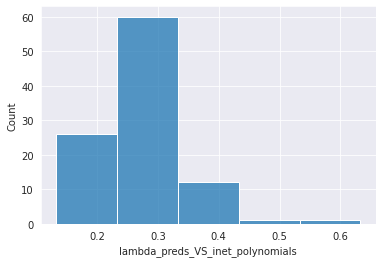

In [50]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

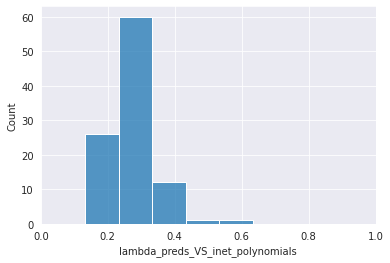

In [51]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


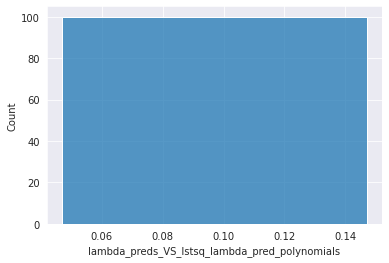

In [52]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

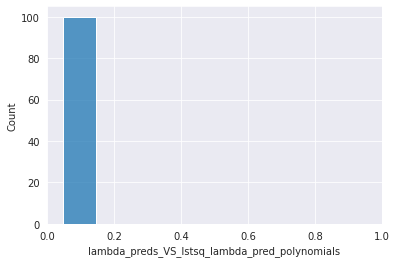

In [53]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


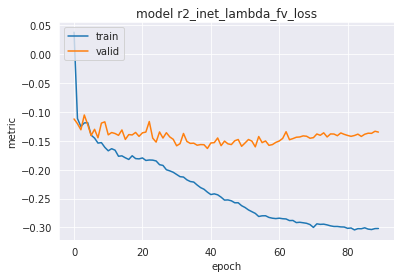

In [54]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    try:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    except:
        pass
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


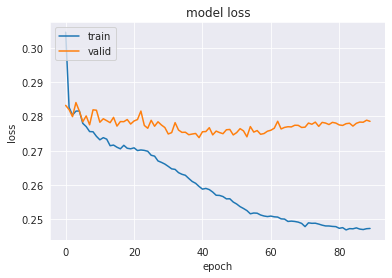

In [55]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    try:
        plt.plot(history['val_loss'])
    except:
        pass
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [56]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [57]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [58]:
if len(scores_test_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [62]:
index = 6

custom_representation_keys_fixed = ['target_polynomials']#['target_polynomials', 'lstsq_target_polynomials', 'lstsq_lambda_pred_polynomials']
custom_representation_keys_dynamic = ['inet_polynomials', 'per_network_polynomials']
sympy_representation_keys = ['metamodel_functions', 'symbolic_regression_functions']


print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

for key in polynomial_dict_test_list[-1].keys():
    if key in custom_representation_keys_fixed:
        print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
        print(key)        
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], force_complete_poly_representation=True, round_digits=4)
        print('MAE: ', distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_' + key][index])
        #print(polynomial_dict_test_list[-1][key][index])
    elif key in custom_representation_keys_dynamic:
        print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
        print(key)              
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], round_digits=4)
        print('MAE: ', distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_' + key][index])
        #print(polynomial_dict_test_list[-1][key][index])
    elif key in sympy_representation_keys:
        print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
        print(key)              
        display(polynomial_dict_test_list[-1][key][index])
        print('MAE: ', distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_' + key][index])
    else:
        pass

print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
target_polynomials


-0.0088*a**2*o + 0.9536*a*d*f + 0.522*a*f*j - 0.0154*b*c*e + 0.678*b*e*j + 0.4465*b*e*k + 0.5049*b*f*i - 0.0221*b*m**2 - 0.0563*c*d**2 - 0.2315*d*f + 0.5649*e*k**2 + 0.4369*f*k*l + 0.5167*g*j*k + 0.516*g*n - 0.5074*j*l*m

MAE:  0.03600722
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
inet_polynomials


0.110500000417233*a*h*m + 0.354099988937378*b*g*l + 0.266299992799759*b*j**2 + 0.0208999998867512*b*o**2 + 0.259499996900558*c*e*m + 0.0505999997258186*c*g*l + 0.267500013113022*c*h*n + 0.176300004124641*d**2*n + 0.216299995779991*d*g*j + 0.703400015830994*e*n + 0.0509000010788441*g*h**2 + 0.170699998736382*g*j + 0.37830001115799*h**2*j + 0.0234999991953373*k*m**2 - 0.19539999961853*l

MAE:  0.2935919
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
metamodel_functions


None

MAE:  nan
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
symbolic_regression_functions


None

MAE:  nan
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


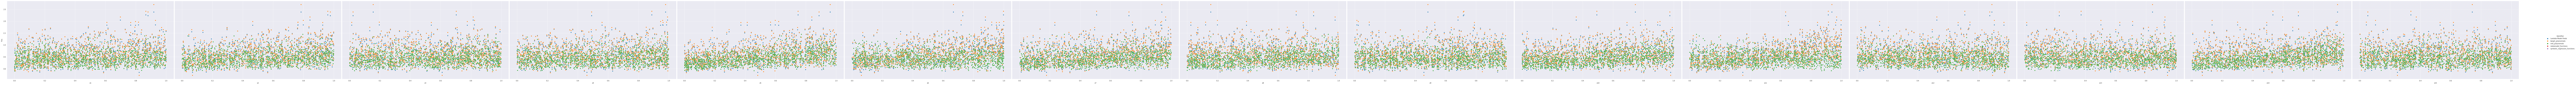

In [60]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

In [61]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

LinAlgError: Singular matrix

ValueError: 'bboxes' cannot be empty

<Figure size 0x0 with 256 Axes>

In [ ]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

In [ ]:
STOP

# BENCHMARK (RANDOM GUESS) EVALUATION

In [ ]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [ ]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

In [ ]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

In [ ]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [ ]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [ ]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

In [ ]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [ ]:
lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
current_jobs = 1

lr=0.5
max_steps = 100
early_stopping=10
restarts=2
per_network_dataset_size = 500

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

if n_jobs != -1:
    n_jobs_per_network = min(n_jobs, os.cpu_count() // current_jobs)
else: 
    n_jobs_per_network = os.cpu_count() // current_jobs - 1

printing = True if n_jobs_per_network == 1 else False


lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
if evaluate_with_real_function: #target polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.target_polynomial_list)
else: #lstsq lambda pred polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list)


config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }


lambda_network_weights = lambda_network_weights_list[0]
poly_representation = poly_representation_list[0]



per_network_poly_optimization_tf(per_network_dataset_size, 
                                lambda_network_weights, 
                                  list_of_monomial_identifiers_numbers, 
                                  config, 
                                  lr=lr, 
                                  max_steps = max_steps, 
                                  early_stopping=early_stopping, 
                                  restarts=restarts, 
                                  printing=True)


# Evaluate Real Dataset


##  Auto MPG-Dataset

In [ ]:
interpretation_possible_autoMPG = False
print_head_autoMPG = None

url_autoMPG = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names_autoMPG = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset_autoMPG = pd.read_csv(url_autoMPG, names=column_names_autoMPG,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset_autoMPG = raw_dataset_autoMPG.dropna()

dataset_autoMPG['Origin'] = dataset_autoMPG['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset_autoMPG = pd.get_dummies(dataset_autoMPG, columns=['Origin'], prefix='', prefix_sep='')


features_autoMPG = dataset_autoMPG.copy()

labels_autoMPG = features_autoMPG.pop('MPG')

features_autoMPG_normalized = (features_autoMPG-features_autoMPG.min())/(features_autoMPG.max()-features_autoMPG.min())

#labels_autoMPG = (labels_autoMPG-labels_autoMPG.min())/(labels_autoMPG.max()-labels_autoMPG.min())


if features_autoMPG_normalized.shape[1] >= n:
    if n == 1:
        features_autoMPG_model = features_autoMPG_normalized[['Horsepower']]
    elif n == features_autoMPG_normalized.shape[1]:
        features_autoMPG_model = features_autoMPG_normalized
    else:
        features_autoMPG_model = features_autoMPG_normalized.sample(n=n, axis='columns')
        
    print_head_autoMPG = features_autoMPG_model.head()
    interpretation_possible_autoMPG = True

print_head_autoMPG

In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    ((lambda_index_autoMPG, 
     current_seed_autoMPG, 
     polynomial_autoMPG, 
     polynomial_lstsq_pred_list_autoMPG, 
     polynomial_lstsq_true_list_autoMPG), 
    scores_list_autoMPG, 
    pred_list_autoMPG, 
    history_autoMPG, 
    model_autoMPG) = train_nn(lambda_index=0, 
                              X_data_lambda=features_autoMPG_model.values, 
                              y_data_real_lambda=labels_autoMPG.values, 
                              polynomial=None, 
                              seed_list=[RANDOM_SEED], 
                              callbacks=[PlotLossesKerasTF()], 
                              return_history=True, 
                              each_epochs_save=None, 
                              printing=False, 
                              return_model=True)
    
    polynomial_lstsq_pred_autoMPG = polynomial_lstsq_pred_list_autoMPG[-1]

In [ ]:
if interpretation_possible_autoMPG and n==1:
    x = tf.linspace(0.0, 250, 251)
    y = model_autoMPG.predict(x)

    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
config = {
        'n': n,
        'd': d,
        'inet_loss': inet_loss,
        'sparsity': sparsity,
        'lambda_network_layers': lambda_network_layers,
        'interpretation_net_output_shape': interpretation_net_output_shape,
        'RANDOM_SEED': RANDOM_SEED,
        'nas': nas,
        'number_of_lambda_weights': number_of_lambda_weights,
        'interpretation_net_output_monomials': interpretation_net_output_monomials,
        'fixed_initialization_lambda_training': fixed_initialization_lambda_training,
        'dropout': dropout,
        'lambda_network_layers': lambda_network_layers,
        'optimizer_lambda': optimizer_lambda,
        'loss_lambda': loss_lambda,        
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }

weights_autoMPG = model_autoMPG.get_weights()

weights_flat_autoMPG = []
for layer_weights, biases in pairwise(weights_autoMPG):    #clf.get_weights()
    for neuron in layer_weights:
        for weight in neuron:
            weights_flat_autoMPG.append(weight)
    for bias in biases:
        weights_flat_autoMPG.append(bias)
        
weights_flat_autoMPG = np.array(weights_flat_autoMPG)


x = pred_list_autoMPG['X_test_lambda']
y = pred_list_autoMPG['y_test_real_lambda']

y_model_autoMPG = model_autoMPG.predict(x)




In [ ]:
if interpretation_possible_autoMPG:
    y_polynomial_lstsq_pred_autoMPG = calculate_function_values_from_polynomial(polynomial_lstsq_pred_autoMPG, x, force_complete_poly_representation=True)

    mae_model_polynomial_lstsq_pred_autoMPGy = mean_absolute_error(y_model_autoMPG, y_polynomial_lstsq_pred_autoMPG)
    mae_data_polynomial_lstsq_pred_autoMPG = mean_absolute_error(y, y_polynomial_lstsq_pred_autoMPG)

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQt Poly:')
    print_polynomial_from_coefficients(y_polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('MAE Model: ', mae_model_polynomial_lstsq_pred_autoMPGy)
    print('MAE Data: ', mae_data_polynomial_lstsq_pred_autoMPG)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    interpretation_net = model_list[-1]
    
    start = time.time() 
    
    #interpretation_net_poly = interpretation_net.predict(np.array([weights_flat_autoMPG]))[0]
    interpretation_net_poly = make_inet_prediction(interpretation_net, weights_flat_autoMPG, network_data=None, lambda_trained_normalized=False, inet_training_normalized=normalize_inet_data, normalization_parameter_dict=None)
    
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_interpretation_net_poly = calculate_function_values_from_polynomial(interpretation_net_poly, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_interpretation_net_poly)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_interpretation_net_poly)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)    
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:

    start = time.time() 
    
    if False:
        per_network_hyperparams = {
            'optimizer':  'Powell',
            'jac': 'fprime',
            'max_steps': 5000,#100,
            'restarts': 3,
            'per_network_dataset_size': 500,
        }      
        
        per_network_function =  per_network_poly_optimization_scipy(per_network_dataset_size, 
                                                                  weights_flat_autoMPG, 
                                                                  list_of_monomial_identifiers_numbers, 
                                                                  config, 
                                                                  optimizer = per_network_hyperparams['optimizer'],
                                                                  jac = per_network_hyperparams['jac'],
                                                                  max_steps = per_network_hyperparams['max_steps'], 
                                                                  restarts=per_network_hyperparams['restarts'], 
                                                                  printing=True,
                                                                  return_error=False)
    else:
        per_network_hyperparams = {
            'optimizer': tf.keras.optimizers.RMSprop,
            'lr': 0.02,
            'max_steps': 500,
            'early_stopping': 10,
            'restarts': 3,
            'per_network_dataset_size': 5000,
        }   
        
        per_network_function =  per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                              weights_flat_autoMPG, 
                                                              list_of_monomial_identifiers_numbers, 
                                                              config, 
                                                              optimizer = per_network_hyperparams['optimizer'],
                                                              lr=per_network_hyperparams['lr'], 
                                                              max_steps = per_network_hyperparams['max_steps'], 
                                                              early_stopping=per_network_hyperparams['early_stopping'], 
                                                              restarts=per_network_hyperparams['restarts'], 
                                                              printing=True,
                                                              return_error=False)
            
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)  
    
    y_per_network_function = calculate_function_values_from_polynomial(per_network_function, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_per_network_function)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_per_network_function)    
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)       
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    
    symbolic_regression_hyperparams = {
        'dataset_size': 500,
    }

    start = time.time() 
    
    symbolic_regression_function =  symbolic_regression(model_autoMPG, 
                                                      config,
                                                      symbolic_regression_hyperparams,
                                                      #printing = True,
                                                      return_error = False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    variable_names = ['X' + str(i) for i in range(n)]
    
    y_symbolic_regression_function = calculate_function_values_from_sympy(symbolic_regression_function, x, variable_names=variable_names)
    
    mae_model_symbolic_regression_function = mean_absolute_error(y_model_autoMPG, y_symbolic_regression_function)
    mae_data_symbolic_regression_function = mean_absolute_error(y, y_symbolic_regression_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Poly:')    
    display(symbolic_regression_function)
    print('MAE Model: ', mae_model_symbolic_regression_function)
    print('MAE Data: ', mae_data_symbolic_regression_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG and True:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = False,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function = calculate_function_values_from_sympy(metamodel_function, x)
    
    mae_model_metamodel_function = mean_absolute_error(y_model_autoMPG, y_metamodel_function)
    mae_data_metamodel_function = mean_absolute_error(y, y_metamodel_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')    
    display(metamodel_function)
    print('MAE Model: ', mae_model_metamodel_function)
    print('MAE Data: ', mae_data_metamodel_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG and False:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function_basic =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = True,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function_basic = calculate_function_values_from_sympy(metamodel_function_basic, x)
    
    mae_metamodel_function_basic = mean_absolute_error(y_model_autoMPG, y_metamodel_function_basic)
    mae_metamodel_function_basic = mean_absolute_error(y, y_metamodel_function_basic)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function Basic:')    
    display(metamodel_function_basic)
    print('MAE Model: ', mae_metamodel_function_basic)
    print('MAE Data: ', mae_metamodel_function_basic)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQ Poly:')
    print_polynomial_from_coefficients(polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Function:')
    display(symbolic_regression_function)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')
    display(metamodel_function)
    #print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    #print('Metamodel Function Basic:')
    #display(metamodel_function_basic)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
if interpretation_possible_autoMPG and n==1:
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    
    ax.set_ylim([0,50])
    
    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.scatter(x, y, label='Test Data')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_model_autoMPG))]) , label='Model Predictions')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_interpretation_net_poly))]) , label='Interpretation Net Poly')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_per_network_function))]) , label='Per Network Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_polynomial_lstsq_pred_autoMPG))]) , label='LSTSQ Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_symbolic_regression_function))]) , label='Symbolic Regression Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_metamodel_function))]) , label='Metamodel Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y))]) y_metamodel_function_basic, label='Metamodel Function Basic')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
sample_data_X = np.array([i for i in range(1000)])
sample_data_y = np.array([3*i for i in range(1000)])

current_seed = 42

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y*1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y+1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:


model_2_weights = model.get_weights()
model_2_normalized_weights = model_2_weights #[weights/10 for weights in model_2_weights]


model_2_normalized_weights[-6] = model_2_normalized_weights[-6]/10
model_2_normalized_weights[-5] = model_2_normalized_weights[-5]/10

model_2_normalized_weights[-4] = model_2_normalized_weights[-4]/10
model_2_normalized_weights[-3] = model_2_normalized_weights[-3]/100

model_2_normalized_weights[-2] = model_2_normalized_weights[-2]/10
model_2_normalized_weights[-1] = model_2_normalized_weights[-1]/1000

model_2.set_weights(model_2_normalized_weights)

print(model_2.get_weights())
print(model_2.predict([1, 10]))

# Evaluate Per-Network Poly Optimization

## Example Optimization (Common Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer':  'Powell',
    'jac': 'fprime',
    'max_steps': 5000,#100,
    'restarts': 3,
    'per_network_dataset_size': 500,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_scipy(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      jac = per_network_hyperparams['jac'],
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Example Optimization (Neural Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer': tf.keras.optimizers.RMSprop,
    'lr': 0.02,
    'max_steps': 500,
    'early_stopping': 10,
    'restarts': 3,
    'per_network_dataset_size': 5000,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      lr = per_network_hyperparams['lr'], 
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      early_stopping = per_network_hyperparams['early_stopping'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error.numpy()))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Grid Search Common Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 10

per_network_hyperparams = {
    'optimizer':  [
                   'Nelder-Mead', 
                   'Powell', 
        
                   'CG',
                   'BFGS',
                   'Newton-CG', 
                   #'L-BFGS-B', #'>' not supported between instances of 'int' and 'NoneType'
                   'TNC', 
                   
                   'COBYLA', 
                   'SLSQP', 
                   
                   #'trust-constr', # TypeError: _minimize_trustregion_constr() got an unexpected keyword argument 'maxfun'
                   #'dogleg', # ValueError: Hessian is required for dogleg minimization
                   #'trust-ncg', #ValueError: Either the Hessian or the Hessian-vector product is required for Newton-CG trust-region minimization
                   #'trust-exact', # ValueError: Hessian matrix is required for trust region exact minimization.
                   #'trust-krylov' #ValueError: Either the Hessian or the Hessian-vector product is required for Krylov trust-region minimization
                   ], 
    'jac': ['fprime'],
    'max_steps': [5000],#100,
    'restarts': [3],
    'per_network_dataset_size': [500],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_scipy)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  jac = params['jac'],
                                                                                  max_steps = params['max_steps'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

## Grid Search Neural Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 100

per_network_hyperparams = {
    'optimizer': [tf.keras.optimizers.RMSprop], #[tf.keras.optimizers.SGD, tf.optimizers.Adam, tf.keras.optimizers.RMSprop, tf.keras.optimizers.Adadelta]
    'lr': [0.02], #[0.5, 0.25, 0.1, 0.05, 0.025]
    'max_steps': [5000],#100,
    'early_stopping': [10],
    'restarts': [3],
    'per_network_dataset_size': [5000],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_tf)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  lr = params['lr'], 
                                                                                  max_steps = params['max_steps'], 
                                                                                  early_stopping = params['early_stopping'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

In [ ]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()


X10*X14*X4*X7 + X10*X2*X3*X6*(-X13 + X2 + X8) - X13*X14*X2*(X1*X11*X3 - X10) - X13 + X14 - X8*(X1*X8*(X10 - X2**3*X6) + X1 + X10*X3 - X10)

